#Part 1

Create function to pull data file from .zip

In [1]:
import os
import zipfile
import requests

def download_data(url, name, path='data'):
    if not os.path.exists(path):
        os.mkdir(path)

    response = requests.get(url)
    with open(os.path.join(path, name), 'wb') as f:
        f.write(response.content)

    z = zipfile.ZipFile(os.path.join(path, 'vehicles.zip'))
    z.extractall(path)

VEHICLES = 'http://bit.ly/ddl-cars'

download_data(VEHICLES, 'vehicles.zip')

In [2]:
import pandas as pd

path = 'data'

vehicles = pd.read_csv(os.path.join(path, 'vehicles.csv'))

/usr/local/src/conda3_runtime.v20/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Clean data - pull interesting columns, drop duplicated data points, drop n/a's, sort data by make, model, and year

In [3]:
select_columns = ['make', 'model', 'year', 'displ', 'cylinders', 'trany', 'drive', 'VClass','fuelType','barrels08', 'city08', 'highway08', 'comb08', 'co2TailpipeGpm', 'fuelCost08']

vehicles = vehicles[select_columns][vehicles.year <= 2016].drop_duplicates().dropna()

vehicles = vehicles.sort_values(['make', 'model', 'year'])

In [4]:
vehicles.head()

,make,model,year,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,comb08,co2TailpipeGpm,fuelCost08
19316,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,19.388824,18,17,17,522.764706,1950
19314,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,13,13,13,683.615385,2550
358,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,20.600625,16,17,16,555.437500,2100
369,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,13,13,13,683.615385,2550
25797,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,20.600625,14,21,16,555.437500,2550


In [5]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35095 entries, 19316 to 29609
Data columns (total 15 columns):
make              35095 non-null object
model             35095 non-null object
year              35095 non-null int64
displ             35095 non-null float64
cylinders         35095 non-null float64
trany             35095 non-null object
drive             35095 non-null object
VClass            35095 non-null object
fuelType          35095 non-null object
barrels08         35095 non-null float64
city08            35095 non-null int64
highway08         35095 non-null int64
comb08            35095 non-null int64
co2TailpipeGpm    35095 non-null float64
fuelCost08        35095 non-null int64
dtypes: float64(4), int64(5), object(6)
memory usage: 4.3+ MB


Rename columns to make more readable

In [6]:
vehicles.columns = ['Make','Model','Year','Engine Displacement','Cylinders',
                    'Transmission','Drivetrain','Vehicle Class','Fuel Type',
                    'Fuel Barrels/Year','City MPG','Highway MPG','Combined MPG',
                    'CO2 Emission Grams/Mile','Fuel Cost/Year']

#Part 2

#Categorical Variables

Looking to simplify data - create higher level categorical variables or remove complexity from data

In [7]:
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(vehicles)

Make | 126 | object
Model | 3490 | object
Year | 33 | int64
Engine Displacement | 65 | float64
Cylinders | 9 | float64
Transmission | 44 | object
Drivetrain | 7 | object
Vehicle Class | 34 | object
Fuel Type | 13 | object
Fuel Barrels/Year | 116 | float64
City MPG | 48 | int64
Highway MPG | 49 | int64
Combined MPG | 46 | int64
CO2 Emission Grams/Mile | 550 | float64
Fuel Cost/Year | 55 | int64


Ex of simplfying data - Transmission: there are 44 types of transmission - they can be broken into Automatic and Manual

In [8]:
len(vehicles.Transmission.unique())

44

In [9]:
vehicles.Transmission.value_counts() 

Automatic 4-spd                     10582
Manual 5-spd                         7764
Automatic 3-spd                      2597
Automatic (S6)                       2455
Manual 6-spd                         2336
Automatic 5-spd                      2171
Automatic 6-spd                      1351
Manual 4-spd                         1306
Automatic (S5)                        822
Automatic (S8)                        774
Automatic (variable gear ratios)      643
Automatic 7-spd                       630
Automatic (S7)                        238
Automatic (S4)                        229
Auto(AM-S7)                           211
Automatic 8-spd                       207
Auto(AV-S6)                           135
Auto(AM7)                             124
Auto(AM6)                             103
Auto(AM-S6)                            82
Manual 3-spd                           74
Manual 7-spd                           56
Auto(AV-S7)                            54
Automatic 9-spd                   

Create "Transmission Type" column, fill column with AUTOMATIC or MANUAL depending on entry in "Transmission" column

In [10]:
AUTOMATIC = "Automatic"
MANUAL = "Manual"

vehicles.loc[vehicles['Transmission'].str.startswith('A'),
             'Transmission Type'] = AUTOMATIC

vehicles.loc[vehicles['Transmission'].str.startswith('M'),
             'Transmission Type'] = MANUAL

Create "Vehicle Category" column, fill new column with small, midsize, or large based on entry in Vehicle Class

In [11]:
small = ['Compact Cars','Subcompact Cars','Two Seaters','Minicompact Cars']
midsize = ['Midsize Cars']
large = ['Large Cars']

vehicles.loc[vehicles['Vehicle Class'].isin(small), 
             'Vehicle Category'] = 'Small Cars'

vehicles.loc[vehicles['Vehicle Class'].isin(midsize), 
             'Vehicle Category'] = 'Midsize Cars'

vehicles.loc[vehicles['Vehicle Class'].isin(large), 
             'Vehicle Category'] = 'Large Cars'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Station'), 
             'Vehicle Category'] = 'Station Wagons'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Truck'), 
             'Vehicle Category'] = 'Pickup Trucks'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Special Purpose'), 
             'Vehicle Category'] = 'Special Purpose'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Sport Utility'), 
             'Vehicle Category'] = 'Sport Utility'

vehicles.loc[(vehicles['Vehicle Class'].str.lower().str.contains('van')),
             'Vehicle Category'] = 'Vans & Minivans'

Combine Make and Model columns into a new column - Model Type: generalized car model

Ex) Categorize all Chevrolet Suburban C1500 2WD vehicles and all Chevrolet Suburban K1500 4WD vehicles as simply Chevrolet Suburbans

In [12]:
vehicles['Model Type'] = (vehicles['Make'] + " " +
                          vehicles['Model'].str.split().str.get(0))

In [13]:
vehicles['Fuel Type'].value_counts()

Regular                        23208
Premium                         9509
Gasoline or E85                 1157
Diesel                           906
Premium or E85                   116
Midgrade                          64
CNG                               60
Gasoline or natural gas           20
Premium and Electricity           16
Premium Gas or Electricity        16
Regular Gas and Electricity       14
Gasoline or propane                8
Regular Gas or Electricity         1
Name: Fuel Type, dtype: int64

Create a column for each Fuel Type - create categorical variables for each fuel type

How: Default each value in new columns (Gas, Ethanol, Electricity, Propane, Natural Gas) to 0, Put a 1 in the appropriate column if a Fuel Type is correct for a given category

Ex) If Fuel Type = "E85" then put 1 in Ethanol column

In [23]:
vehicles['Gas'] = 0
vehicles['Ethanol'] = 0
vehicles['Electric'] = 0
vehicles['Propane'] = 0
vehicles['Natural Gas'] = 0

vehicles.loc[vehicles['Fuel Type'].str.contains(
        'Regular|Gasoline|Midgrade|Premium|Diesel'),'Gas'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('E85'),'Ethanol'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('Electricity'),'Electric'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('propane'),'Propane'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('natural|CNG'),'Natural Gas'] = 1

Create Gas Type Column to further categorize gas types based on data in Fuel Type column

In [25]:
vehicles.loc[vehicles['Fuel Type'].str.contains(
        'Regular|Gasoline'),'Gas Type'] = 'Regular'

vehicles.loc[vehicles['Fuel Type'] == 'Midgrade',
             'Gas Type'] = 'Midgrade'

vehicles.loc[vehicles['Fuel Type'].str.contains('Premium'),
             'Gas Type'] = 'Premium'

vehicles.loc[vehicles['Fuel Type'] == 'Diesel',
             'Gas Type'] = 'Diesel'

vehicles.loc[vehicles['Fuel Type'].str.contains('natural|CNG'),
             'Gas Type'] = 'Natural'

#Binning

When working with continous variables, bin them to make them easier - def of bin: combine into discrete buckets by creating ranges

Ex) In marketing - create customer cohorts to buckets consumers into similar joining times

Use qcut function - pandas.qcut(Series, # of quintiles/buckets, labels)

In [36]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35095 entries, 19316 to 29609
Data columns (total 24 columns):
Make                       35095 non-null object
Model                      35095 non-null object
Year                       35095 non-null int64
Engine Displacement        35095 non-null float64
Cylinders                  35095 non-null float64
Transmission               35095 non-null object
Drivetrain                 35095 non-null object
Vehicle Class              35095 non-null object
Fuel Type                  35095 non-null object
Fuel Barrels/Year          35095 non-null float64
City MPG                   35095 non-null int64
Highway MPG                35095 non-null int64
Combined MPG               35095 non-null int64
CO2 Emission Grams/Mile    35095 non-null float64
Fuel Cost/Year             35095 non-null int64
Transmission Type          35095 non-null object
Vehicle Category           35095 non-null object
Model Type                 35095 non-null object
Gas   

Combined MPG, Engine Size, Emissions, Fuel Costs - bucket into 5 categories 

In [44]:
efficiency_categories = ['Very Low Efficiency', 'Low Efficiency',
                         'Moderate Efficiency','High Efficiency',
                         'Very High Efficiency']

vehicles['Fuel Efficiency'] = pd.qcut(vehicles['Combined MPG'],
                                      5, efficiency_categories)

In [45]:
engine_categories = ['Very Small Engine', 'Small Engine','Moderate Engine',
                     'Large Engine', 'Very Large Engine']

vehicles['Engine Size'] = pd.qcut(vehicles['Engine Displacement'],
                                  5, engine_categories)

In [46]:
emission_categories = ['Very Low Emissions', 'Low Emissions',
                        'Moderate Emissions','High Emissions',
                        'Very High Emissions']

vehicles['Emissions'] = pd.qcut(vehicles['CO2 Emission Grams/Mile'],
                                 5, emission_categories)

In [47]:
fuelcost_categories = ['Very Low Fuel Cost', 'Low Fuel Cost',
                       'Moderate Fuel Cost','High Fuel Cost',
                       'Very High Fuel Cost']

vehicles['Fuel Cost'] = pd.qcut(vehicles['Fuel Cost/Year'],
                                5, fuelcost_categories)

#Clustering 

Create new features from related variables, use numerical variables ONLY

In [48]:
cluster_columns = ['Engine Displacement','Cylinders','Fuel Barrels/Year',
                   'City MPG','Highway MPG','Combined MPG',
                   'CO2 Emission Grams/Mile', 'Fuel Cost/Year']

Scale numerical values so that they retain their distribution but are numbers between 0 and 1 (Purpose: mathematical convenience?)

In [49]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

vehicle_clusters = scaler.fit_transform(vehicles[cluster_columns])
vehicle_clusters = pd.DataFrame(vehicle_clusters, columns=cluster_columns)

K means cluster to create groups - create new features based on group characteristics

Explanation: https://www.quora.com/What-is-a-k-means-algorithm

In [50]:
from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=1)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [51]:
def summarize_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    return cluster_summary

Creates 4 clusters (based on iteration to see the number of clusters that is mutually exclusive,collectively exhaustive - this part is more art than science...)

In [52]:
cluster_results = kmeans_cluster(vehicle_clusters, 4)
cluster_summary = summarize_clustering(cluster_results)

In [54]:
cluster_summary

,Cluster,Count,Engine Displacement,Cylinders,Fuel Barrels/Year,City MPG,Highway MPG,Combined MPG,CO2 Emission Grams/Mile,Fuel Cost/Year
0,0,8195,0.230890,0.251411,0.266962,0.413265,0.515462,0.478114,0.267262,0.227753
1,1,8188,0.513292,0.428325,0.423538,0.253255,0.329058,0.296837,0.425091,0.370426
2,2,13603,0.330854,0.322369,0.352043,0.303940,0.397599,0.357866,0.352017,0.308864
3,3,5109,0.659905,0.527770,0.533567,0.204116,0.266030,0.239825,0.533659,0.465684


Visualization of clustering

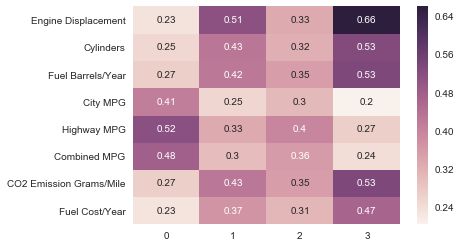

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True)

Create descriptive labels for clusters - Remember the graph shows rescaled, average values for given variables.

Ex - Cluster 3 has a large amount of engine displacement, lots of cylinders, lost of emissions, and high fuel costs -> "Large Inefficient"

In [57]:
cluster_results['Cluster Name'] = ''
cluster_results['Cluster Name'][cluster_results['Cluster']==2] = 'Midsized Balanced'
cluster_results['Cluster Name'][cluster_results['Cluster']==3] = 'Large Inefficient'
cluster_results['Cluster Name'][cluster_results['Cluster']==1] = 'Large Moderately Efficient'
cluster_results['Cluster Name'][cluster_results['Cluster']==0] = 'Small Very Efficient'

vehicles = vehicles.reset_index().drop('index', axis=1)
vehicles['Cluster Name'] = cluster_results['Cluster Name']

C:\Users\benbl\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\benbl\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\benbl\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\benbl\Anaconda3\lib\

In [59]:
vehicles.head()

,Make,Model,Year,Engine Displacement,Cylinders,Transmission,Drivetrain,Vehicle Class,Fuel Type,Fuel Barrels/Year,...,Ethanol,Electric,Propane,Natural Gas,Gas Type,Fuel Efficiency,Engine Size,Emissions,Fuel Cost,Cluster Name
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,19.388824,...,0,0,0,0,Regular,Low Efficiency,Small Engine,High Emissions,Moderate Fuel Cost,Midsized Balanced
1,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,...,0,0,0,0,Regular,Very Low Efficiency,Large Engine,Very High Emissions,Very High Fuel Cost,Large Moderately Efficient
2,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,20.600625,...,0,0,0,0,Regular,Very Low Efficiency,Small Engine,High Emissions,High Fuel Cost,Midsized Balanced
3,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,...,0,0,0,0,Regular,Very Low Efficiency,Large Engine,Very High Emissions,Very High Fuel Cost,Large Moderately Efficient
4,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,20.600625,...,0,0,0,0,Premium,Very Low Efficiency,Large Engine,High Emissions,Very High Fuel Cost,Large Moderately Efficient


#Part 3